In [3]:
import numpy as np
import pandas as pd
import math
import time
import os
import sys
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore')
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from hyperopt import hp
start = time.time()
import pickle

# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

## LC informations
# Import LC informations
path = os.getcwd()
data_path = path+"/data/extract_data.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

# Remove non_retained molecules
index=lc_df[lc_df['Exp_RT'] < 180].index
lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
data_path = path+"/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

# Remove non_retained molecules
des_df  = des_df.drop(des_df.index[[index]])


#load the model with lc
path = os.getcwd()
dirname = os.path.dirname(path)
file_path = dirname+"/p_chem/hyperparameters/xgb_lc.pkl"
best_parameters_with_lc = pickle.load(open(file_path,'rb'))

space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
          'gamma': hp.uniform('gamma', 0, 0.2),
          'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
          'subsample': hp.uniform('subsample', 0.7, 1.0),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
          'max_depth': hp.choice('max_depth', range(3, 10)),
          'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 400, 500, 1000])}
min_child_weight_ls = range(1, 6)
max_depth_ls = range(3, 10)
n_estimators_ls = [100, 200, 300, 400, 500, 1000, 1500, 2000]

In [6]:
train , rest = train_test_split(data,train_size = 0.8,shuffle=True,random_state = seed)
validate , test = train_test_split(rest, train_size = 0.5, shuffle=True,random_state = seed)

# training set
data_tra_x = train.drop(['LogP'],axis=1)
data_tra_y = train['LogP']

# validation set
data_val_x = validate.drop(['LogP'],axis=1)
data_val_y = validate['LogP']

# test set
data_tes_x = test.drop(['LogP'],axis=1)
data_tes_y = test['LogP']

best_model = XGBRegressor( n_estimators=n_estimators_ls[best_parameters_with_lc['n_estimators']], 
                                max_depth=max_depth_ls[best_parameters_with_lc['max_depth']],
                                min_child_weight=min_child_weight_ls[best_parameters_with_lc['min_child_weight']],
                                learning_rate=best_parameters_with_lc['learning_rate'],
                                gamma=best_parameters_with_lc['gamma'],
                                subsample=best_parameters_with_lc['subsample'],
                                colsample_bytree=best_parameters_with_lc['colsample_bytree'],
                                n_jobs=6, random_state=1, seed=1)

best_model.fit(data_tra_x,data_tra_y)

NameError: name 'data' is not defined

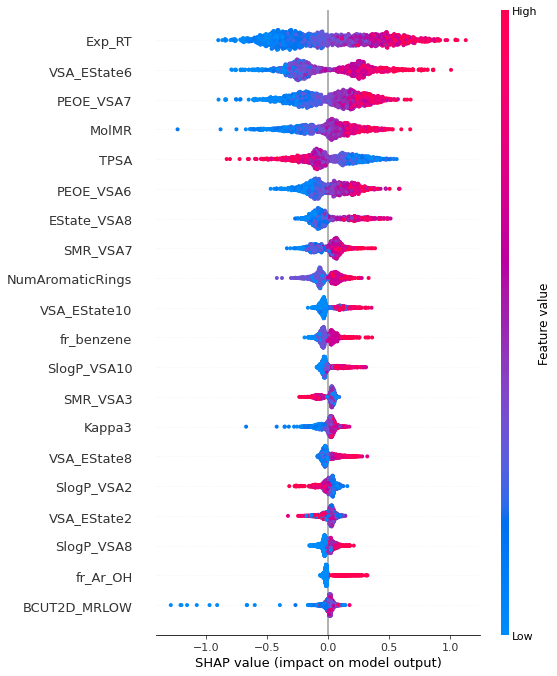

In [10]:
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
data = des_with_lc.drop(['LogP'],axis=1)

# Remove features with low Variance(threshold<=0.05)
data_var = data.var()
del_feat = list(data_var[data_var <= 0.05].index)
data.drop(columns=del_feat, inplace=True)

# Remove features with correlation(threshold > 0.95)
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
data = data.drop(to_drop,axis=1)

# Scale the features
cols = list(data)
data[cols] = data[cols].apply(scale,axis=0)
data = pd.concat([data,des_with_lc['LogP']],axis=1)


X = data.drop(['LogP'],axis=1)
y = data['LogP']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
model = XGBRegressor()
model.fit(X_train, Y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train)

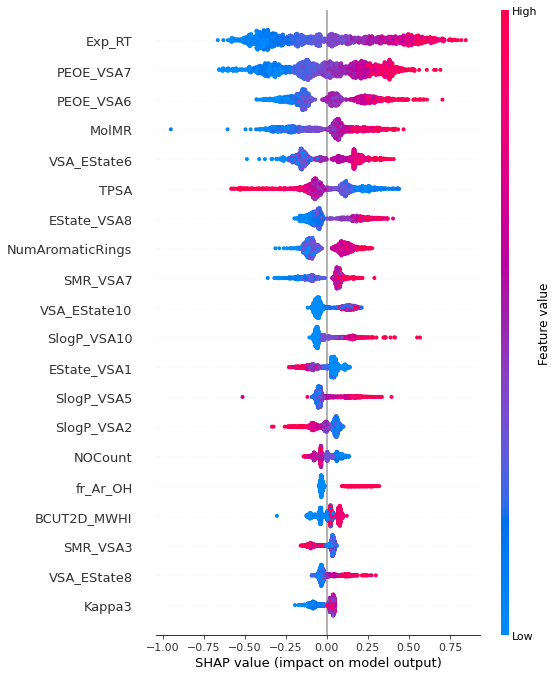

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
data = des_with_lc.drop(['LogP'],axis=1)

# Remove features with low Variance(threshold<=0.05)
data_var = data.var()
del_feat = list(data_var[data_var <= 0.05].index)
data.drop(columns=del_feat, inplace=True)

# Remove features with correlation(threshold > 0.95)
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
data = data.drop(to_drop,axis=1)

# Scale the features
cols = list(data)
data[cols] = data[cols].apply(scale,axis=0)
data = pd.concat([data,des_with_lc['LogP']],axis=1)


X = data.drop(['LogP'],axis=1)
y = data['LogP']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train)
#f.savefig("summary_plot_with_lc.png", bbox_inches='tight', dpi=600)

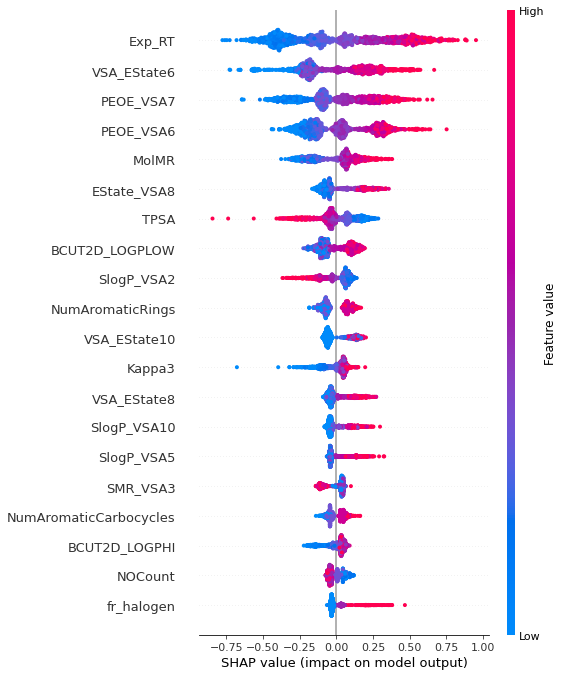

In [13]:
# with lc
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]

# Scale the features
no_target = des_with_lc.drop(['LogP'],axis=1)
cols = list(no_target)
no_target[cols] = no_target[cols].apply(scale,axis=0)

# data set preparation
data = pd.concat([no_target,des_with_lc['LogP']],axis=1)
X = data.drop(['LogP'],axis=1)
y = data['LogP']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train)
#f.savefig("summary_plot_with_lc.png", bbox_inches='tight', dpi=600)

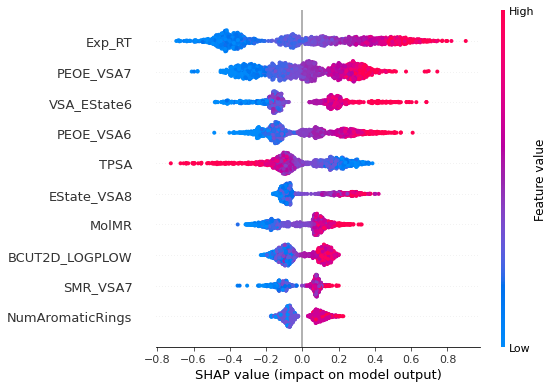

In [19]:
import numpy as np
import pandas as pd
import math
import time
import os
import sys
import shap
import warnings
warnings.simplefilter(action='ignore')
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
start = time.time()
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

## LC informations
# Import LC informations
path = os.getcwd()
data_path = dirname+"/p_chem/data/extract_data.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

# Remove non_retained molecules
index=lc_df[lc_df['Exp_RT'] < 180].index
lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
data_path = dirname+"/p_chem/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

# Remove non_retained molecules
des_df  = des_df.drop(des_df.index[[index]])

# data
# des_without_lc = pd.concat([des_df,lc_df['LogP']],axis=1)
# des_without_lc_feat_corr = des_without_lc.columns[des_without_lc.corrwith(des_without_lc['LogP']) >=0.90][:-1]
# des_without_lc = des_without_lc.drop(columns=des_without_lc_feat_corr)

# # Filling the nan with mean values in des_with_lc
# for col in des_without_lc:
#     des_without_lc[col].fillna(des_without_lc[col].mean(),inplace=True)

# # Remove columns with zero vlues
# des_without_lc = des_without_lc.loc[:,(des_without_lc**2).sum() != 0]

# # Scale the features
# no_target = des_without_lc.drop(['LogP'],axis=1)
# cols = list(no_target)
# no_target[cols] = no_target[cols].apply(scale,axis=0)

# # data set preparation
# data = pd.concat([no_target,des_without_lc['LogP']],axis=1)
# X = data.drop(['LogP'],axis=1)
# y = data['LogP']
# X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
# model = RandomForestRegressor()
# model.fit(X_train, Y_train)
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# f = plt.figure()
# shap.summary_plot(shap_values, X_train)
# f.savefig("summary_plot_without_lc.png", bbox_inches='tight', dpi=600)



######################################
# with lc
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]

# Scale the features
no_target = des_with_lc.drop(['LogP'],axis=1)
cols = list(no_target)
no_target[cols] = no_target[cols].apply(scale,axis=0)

# data set preparation
data = pd.concat([no_target,des_with_lc['LogP']],axis=1)
X = data.drop(['LogP'],axis=1)
y = data['LogP']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,max_display=10)
f.savefig("summary_plot_with_lc_11.png", bbox_inches='tight', dpi=600)


####

# des_with_lc = pd.concat([des_df,lc_df],axis=1)
# des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
# des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# # Filling the nan with mean values in des_with_lc
# for col in des_with_lc:
#     des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# # Remove columns with zero vlues
# des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]

# # Scale the features
# no_target = des_with_lc.drop(['LogP'],axis=1)
# cols = list(no_target)
# no_target[cols] = no_target[cols].apply(scale,axis=0)

# # data set preparation
# data = pd.concat([no_target,des_with_lc['LogP']],axis=1)
# X = data.drop(['LogP','LogD'],axis=1)
# y = data['LogP']
# X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
# model = GradientBoostingRegressor()
# model.fit(X_train, Y_train)
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# f = plt.figure()
# shap.summary_plot(shap_values, X_train)
#f.savefig("summary_plot_with_lc.png", bbox_inches='tight', dpi=600)


############

# des_with_lc = pd.concat([des_df,lc_df],axis=1)
# des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
# des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# # Filling the nan with mean values in des_with_lc
# for col in des_with_lc:
#     des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# # Remove columns with zero vlues
# des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
# data = des_with_lc.drop(['LogP'],axis=1)

# # Remove features with low Variance(threshold<=0.05)
# data_var = data.var()
# del_feat = list(data_var[data_var <= 0.05].index)
# data.drop(columns=del_feat, inplace=True)

# # Remove features with correlation(threshold > 0.95)
# corr_matrix = data.corr().abs()
# mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
# tri_df = corr_matrix.mask(mask)
# to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
# data = data.drop(to_drop,axis=1)

# # Scale the features
# cols = list(data)
# data[cols] = data[cols].apply(scale,axis=0)
# data = pd.concat([data,des_with_lc['LogP']],axis=1)


# X = data.drop(['LogP'],axis=1)
# y = data['LogP']
# X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
# model = GradientBoostingRegressor()
# model.fit(X_train, Y_train)
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# f = plt.figure()
# shap.summary_plot(shap_values, X_train)
#f.savefig("summary_plot_with_lc.png", bbox_inches='tight', dpi=600)

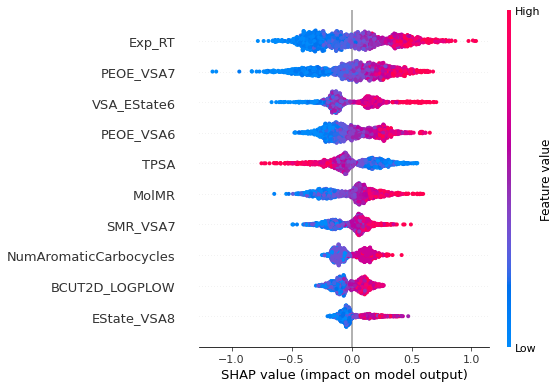

In [51]:
import numpy as np
import pandas as pd
import math
import time
import os
import sys
import shap
import warnings
warnings.simplefilter(action='ignore')
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
start = time.time()
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

## LC informations
# Import LC informations
path = os.getcwd()
data_path = dirname+"/p_chem/data/extract_data.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

# Remove non_retained molecules
index=lc_df[lc_df['Exp_RT'] < 180].index
lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
data_path = dirname+"/p_chem/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

# Remove non_retained molecules
des_df  = des_df.drop(des_df.index[[index]])


######################################
# with lc
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]

# Scale the features
no_target = des_with_lc.drop(['LogP'],axis=1)
cols = list(no_target)
no_target[cols] = no_target[cols].apply(scale,axis=0)

# data set preparation
data = pd.concat([no_target,des_with_lc['LogP']],axis=1)
X = data.drop(['LogP'],axis=1)
y = data['LogP']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
model = XGBRegressor()
model.fit(X_train, Y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,max_display=10)
f.savefig("summary_plot_with_lc_12.png", bbox_inches='tight', dpi=600)


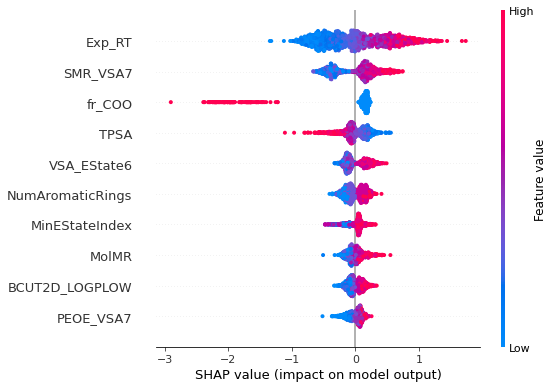

In [61]:
import numpy as np
import pandas as pd
import math
import time
import os
import sys
import shap
import warnings
warnings.simplefilter(action='ignore')
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
start = time.time()
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

## LC informations
# Import LC informations
path = os.getcwd()
data_path = dirname+"/p_chem/data/extract_data.csv"
col_list=['LogD','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

# Remove non_retained molecules
index=lc_df[lc_df['Exp_RT'] < 180].index
lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
data_path = dirname+"/p_chem/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

# Remove non_retained molecules
des_df  = des_df.drop(des_df.index[[index]])


######################################
# with lc
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogD']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]

# Scale the features
no_target = des_with_lc.drop(['LogD','MolLogP'],axis=1)
cols = list(no_target)
no_target[cols] = no_target[cols].apply(scale,axis=0)

# data set preparation
data = pd.concat([no_target,des_with_lc['LogD']],axis=1)
X = data.drop(['LogD'],axis=1)
y = data['LogD']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)
model = XGBRegressor()
model.fit(X_train, Y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,max_display=10)
f.savefig("summary_plot_with_lc_logd_10.png", bbox_inches='tight', dpi=600)
